In [1]:
from preprocessing import parse_annotation,BatchGenerator
import numpy as np
from frontend import YOLO
from matplotlib import pyplot as plt


C:\Users\ZMJ\Anaconda3\envs\py35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
config=dict()
config["train"]=dict()
config["model"]=dict()
config["valid"]=dict()
config["valid"]["valid_times"]=1
config["train"]["train_annot_folder"]="RBC_datasets/Annotations/"
config["train"]["train_image_folder"]="RBC_datasets/JPEGImages/"
config["train"]["train_times"]=1
config["train"]["batch_size"]=16
config["train"]["learning_rate"]=1e-4
config["train"]["nb_epoch"]=50
config["train"]["warmup_batches"]=250
config["train"]["object_scale"]=5.0
config["train"]["no_object_scale"]=1.0
config["train"]["coord_scale"]=1.0
config["train"]["class_scale"]=1.0
config["model"]["labels"]=["RBC"]
config["model"]["input_size"]=416
config["model"]["max_box_per_img"]=10
config["model"]["anchors"]=[0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]
config["model"]["architecture"]="Tiny Yolo"
config["model"]["grid_w"]=13
config["model"]["grid_h"]=13

weights_path="models/tiny_yolo.h5"

In [3]:
imgs,_=parse_annotation(config["train"]["train_annot_folder"],
                        config["train"]["train_image_folder"],
                        config["model"]["labels"]
                       )
split_idx=int(0.8*len(imgs))
np.random.shuffle(imgs)
train_imgs=imgs[:split_idx]
valid_imgs=imgs[split_idx:]
print(train_imgs[0])

{'filename': 'RBC_datasets/JPEGImages/BloodImage_00137.jpg', 'width': 640, 'object': [{'xmax': 273, 'ymin': 333, 'name': 'RBC', 'xmin': 146, 'ymax': 459}, {'xmax': 316, 'ymin': 247, 'name': 'RBC', 'xmin': 211, 'ymax': 360}, {'xmax': 208, 'ymin': 145, 'name': 'RBC', 'xmin': 79, 'ymax': 264}, {'xmax': 555, 'ymin': 231, 'name': 'RBC', 'xmin': 466, 'ymax': 320}], 'height': 480}


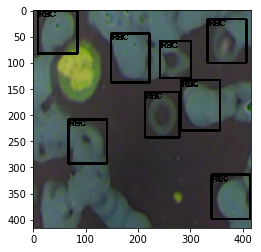

(416, 416, 3)
(13, 13, 5, 6)


In [4]:
generator_config={
        "IMAGE_H":config["model"]["input_size"],
        "IMAGE_W":config["model"]["input_size"],
        "GRID_H":config["model"]["grid_h"],
        "GRID_W":config["model"]["grid_w"],
        "BOX":5,
        "LABELS":config["model"]["labels"],
        "CLASS":len(config["model"]["labels"]),
        "ANCHORS":config["model"]["anchors"],
        "BATCH_SIZE":config["train"]["batch_size"],
        "TRUE_BOX_BUFFER":config["model"]["max_box_per_img"]
        }

generator=BatchGenerator(train_imgs,generator_config,norm=None)
[x,b],y=generator.__getitem__(0)
plt.imshow(x[0])
plt.show()
print(x[0].shape)
print(y[0].shape)

In [12]:
yolo=YOLO(architecture=config["model"]["architecture"],
            input_size=config["model"]["input_size"],
            labels=config["model"]["labels"],
            max_box_per_img=config["model"]["max_box_per_img"],
            anchors=config["model"]["anchors"])

yolo.train(
      train_imgs,
      valid_imgs,
      config["train"]["train_times"],
      config["valid"]["valid_times"],
      config["train"]["nb_epoch"],
      config["train"]["learning_rate"],
      config["train"]["batch_size"],
      config["train"]["warmup_batches"],
      config["train"]["object_scale"],
      config["train"]["no_object_scale"],
      config["train"]["coord_scale"],
      config["train"]["class_scale"],train=False)
yolo.load_weights(weights_path)

load weights from models/tiny_yolo_backend.h5


In [22]:
[test_x,test_b],test_y=yolo.compute_loss(train_imgs)
netout=yolo.model.predict([np.expand_dims(test_x,0),np.expand_dims(test_b,0)])[0]


16/16 [==============================] - 1s 69ms/step
The first batch loss is 0.27877581119537354
16
1/1 [==============================] - 0s 154ms/step
The first img loss is 1.408020257949829
1/1 [==============================] - 0s 129ms/step
The first img loss is 1.2866783142089844
1/1 [==============================] - 0s 127ms/step
The first img loss is 0.7231379151344299
1/1 [==============================] - 0s 147ms/step
The first img loss is 1.380964994430542
1/1 [==============================] - 0s 150ms/step
The first img loss is 1.4758809804916382
1/1 [==============================] - 0s 144ms/step
The first img loss is 0.7711873650550842
1/1 [==============================] - 0s 153ms/step
The first img loss is 2.019895315170288
1/1 [==============================] - 0s 174ms/step
The first img loss is 1.6533268690109253
1/1 [==============================] - 0s 170ms/step
The first img loss is 1.7217239141464233
1/1 [==============================] - 0s 162ms/step
The

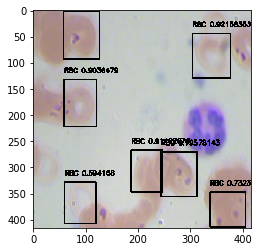

In [23]:
from utils import decode_netout,draw_boxes
boxes=decode_netout(netout,0.51,0.2,config["model"]["anchors"],len(config["model"]["labels"]))
test_x_copy=test_x.copy()
img=draw_boxes(boxes,test_x_copy,config["model"]["labels"])
plt.imshow(img)
plt.show()